### What do we need nlevleaf to be given allometry parameters?

In [1]:
from scipy.stats import qmc
import numpy as np

import csv
import xarray as xr
import pandas as pd
import os
import netCDF4 as nc4
import sys
import shutil
from tempfile import TemporaryFile                                                                                                                                 
import argparse                                                                                                                                                                                                                                                                                                       
import tempfile 
import random
import re

import scipy.optimize as opt

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib.colors import BoundaryNorm


In [2]:
pftnames = ['broadleaf_evergreen_tropical_tree','needleleaf_evergreen_extratrop_tree',
         'needleleaf_colddecid_extratrop_tree','broadleaf_evergreen_extratrop_tree',
        'broadleaf_hydrodecid_tropical_tree','broadleaf_colddecid_extratrop_tree',
        'broadleaf_evergreen_extratrop_shrub','broadleaf_hydrodecid_extratrop_shrub',
        'broadleaf_colddecid_extratrop_shrub', 'arctic_c3_grass',
        'cool_c3_grasss','c4_grass']

## Functions

In [3]:
def d2ca (d, p1) :
    ca = d ** p1
    return ca

In [4]:
def d2bleaf (d, p1, p2, p3, rho) :
    blmax = p1 * d**p2 * rho**p3
    return blmax

In [5]:
def decay_coeff_kn ( vcmax25top ) :
    kn = np.exp(0.00963 * vcmax25top  - 2.43)
    return kn


In [6]:
def tree_lai ( leaf_c, c_area, vcmax25top, slatop, slamax) :
    
    g_per_kg = 1000.0
    slat = g_per_kg * slatop
    leafc_per_unitarea = leaf_c / c_area
    canopy_lai_above = 0
        
    kn = decay_coeff_kn(vcmax25top)
    sla_max = g_per_kg * slamax
    leafc_slamax = (slat - sla_max * np.exp(-1.0 * kn * canopy_lai_above)) / (
        -1.0 * kn * slat * sla_max) 
    
    if (leafc_per_unitarea <= leafc_slamax) : 
        tree_lai = (np.log (np.exp(-1 * kn * canopy_lai_above) - kn * slat  * leafc_per_unitarea) + 
                    (kn * canopy_lai_above)) / (-1 * kn)
    else : 
        tree_lai = ((np.log (np.exp(1 * kn * canopy_lai_above) - kn * slat * leafc_slamax) + 
                     (kn * canopy_lai_above)) / (-1 * kn))  +  (leafc_per_unitarea -
                                                                leafc_slamax) * sla_max
        
    return tree_lai
    

## Constants - these are a mix of pft parameters and hard coded values 

In [7]:
wood_density = [0.548327, 0.442350, 0.454845, 0.754336, 0.548327, 0.566452, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7]
vcmax25top  = [57.5, 34.1, 33.15, 33.55, 28.7, 31.9, 71.3, 62.1, 37.8, 42.9, 31.2, 78]
nitr_stoich  = [0.033, 0.029, 0.04, 0.033, 0.04, 0.04, 0.033, 0.04, 0.04, 0.04, 0.04, 0.04]
slatop = [0.0144, 0.006, 0.0288, 0.0108, 0.036, 0.036, 0.0144, 0.036, 0.036, 0.036, 0.036, 0.03]
slamax= [0.0954, 0.0954, 0.0954, 0.0954, 0.0954, 0.0954, 0.012, 0.03, 0.03, 0.03, 0.03, 0.03]
lnc_top =  [a / b for a,  b  in  zip(nitr_stoich,  slatop)]
umolC_to_kgC = 12.0e-9
g_per_kg = 1000.0
d2bl1 = [0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07]
d2bl2 =[1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3]
d2bl3 = [0.55, 0.55, 0.55, 0.55, 0.55, 0.55, 0.55, 0.55, 0.55, 0.55, 0.55, 0.55]
blca_expnt_diff = [-0.12366731, -0.3447603, -0.31791391, -0.21568348, -0.12366731, -0.3521357, 0, 0, 0, 0, 0, 0]

cap1 = [a+b for a,b in zip(d2bl2, blca_expnt_diff)]
print(cap1)

[1.17633269, 0.9552397, 0.98208609, 1.08431652, 1.17633269, 0.9478643, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3]


## Tree LAI

''

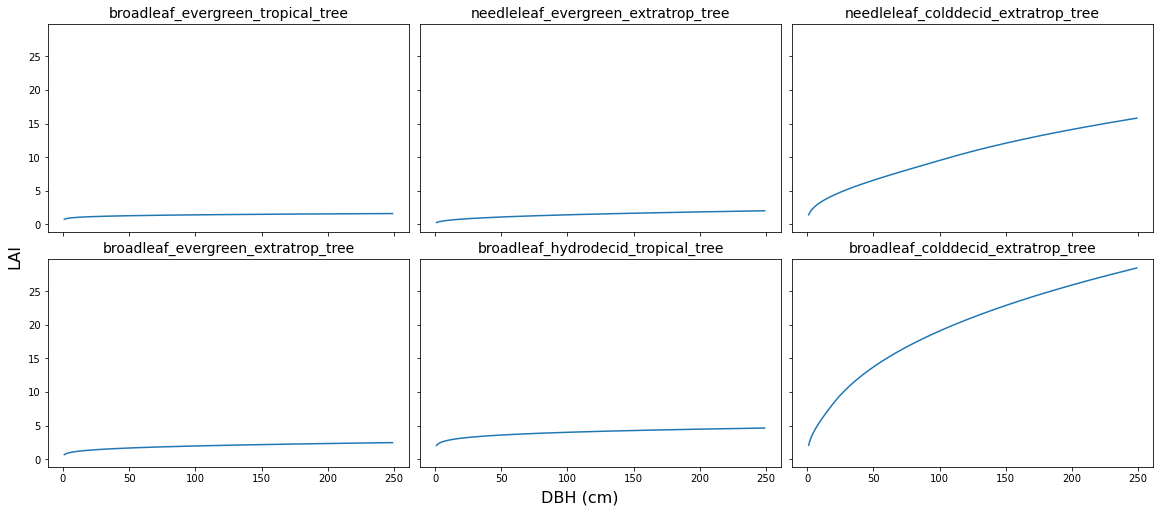

In [8]:
fig2, axs = plt.subplots(nrows=2,ncols=3,
                        figsize=(16,7), constrained_layout=True, sharex=True, sharey=True)

axs = axs.flatten()

# for each tree PFT calculate total vai
for pf in range(0, 6) : 
    
    dbh = np.arange(1,250,1)
    
    # calculate leaf carbon
    leaf_c_curve = d2bleaf(dbh, d2bl1[pf], d2bl2[pf], d2bl3[pf], wood_density[pf]) 
    
    # calculate crown area
    ca_curve = d2ca(dbh, cap1[pf])
    
    lai_curve = [tree_lai( leaf_c, c_area, vcmax25top[pf], slatop[pf], slamax[pf])
             for leaf_c, c_area in zip(leaf_c_curve, ca_curve)]
    
    axs[pf].plot(dbh, lai_curve)
    axs[pf].set_title(pftnames[pf], fontsize=14)

fig2.supylabel('LAI', fontsize=16)
fig2.supxlabel('DBH (cm)', fontsize=16)  
;

### Plot leaf biomass

Text(0.5, 0.01, 'DBH (cm)')

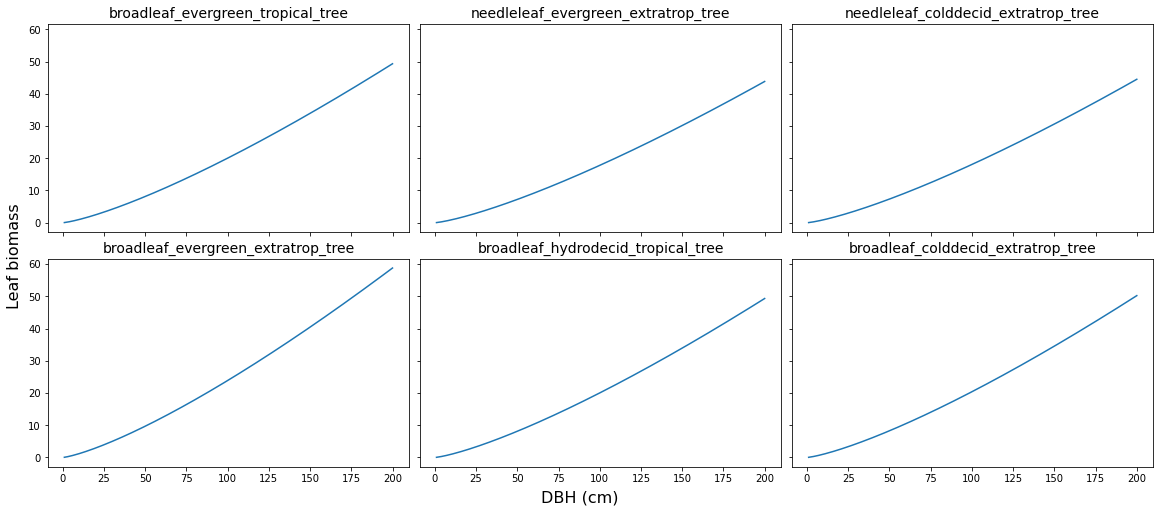

In [9]:
fig2, axs = plt.subplots(nrows=2,ncols=3,
                        figsize=(16,7), constrained_layout=True, sharex=True, sharey=True)

axs = axs.flatten()

dbh = np.linspace(1,200,200)

for pf in range(0,6):
    bleaf_curve = [d2bleaf(d, d2bl1[pf], d2bl2[pf], d2bl3[pf], wood_density[pf])  for  d  in dbh]
    axs[pf].plot(dbh, bleaf_curve)
    axs[pf].set_title(pftnames[pf], fontsize=14)

fig2.supylabel('Leaf biomass', fontsize=16)
fig2.supxlabel('DBH (cm)', fontsize=16)    

### Plot crown area

Text(0.5, 0.01, 'DBH (cm)')

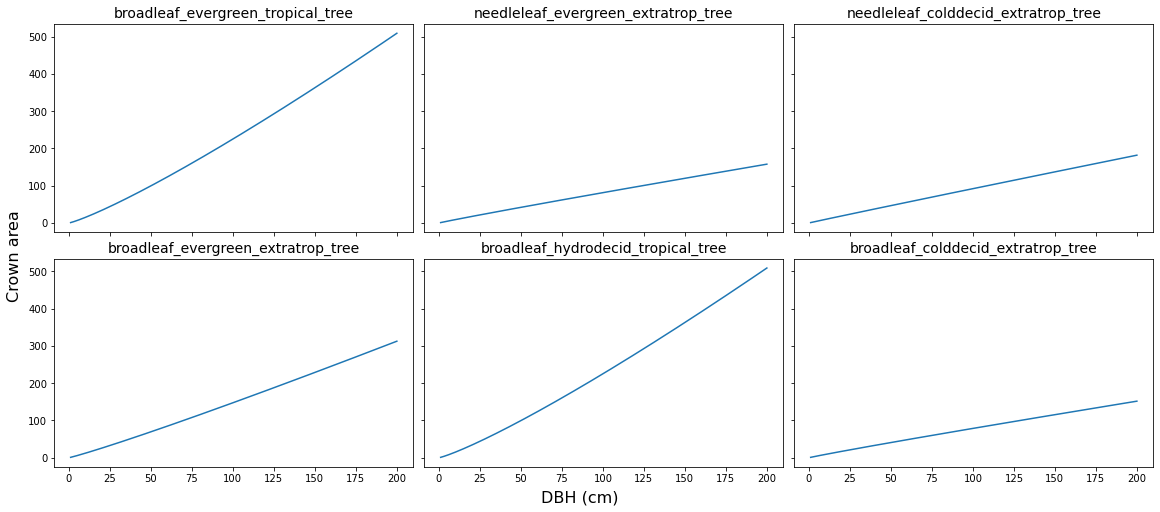

In [10]:
fig2, axs = plt.subplots(nrows=2,ncols=3,
                        figsize=(16,7), constrained_layout=True, sharex=True, sharey=True)

axs = axs.flatten()

dbh = np.linspace(1,200,200)

for pf in range(0,6):
    ca_curve = [d2ca(d, cap1[pf])  for  d  in dbh]
    axs[pf].plot(dbh, ca_curve)
    axs[pf].set_title(pftnames[pf], fontsize=14)

fig2.supylabel('Crown area', fontsize=16)
fig2.supxlabel('DBH (cm)', fontsize=16)    

## Now with bleaf and CA exponents the same

In [12]:
# switch to  simpler leaf biomass  equation 
def d2bleaf (d, p1, p2, c2b) :
    blmax = (p1 * d**p2) / c2b
    return blmax

In [13]:
vcmax25top  = [57.5, 34.1, 33.15, 33.55, 28.7, 31.9, 71.3, 62.1, 37.8, 42.9, 31.2, 78]
nitr_stoich  = [0.033, 0.029, 0.04, 0.033, 0.04, 0.04, 0.033, 0.04, 0.04, 0.04, 0.04, 0.04]
slatop = [0.0144, 0.006, 0.0288, 0.0108, 0.036, 0.036, 0.0144, 0.036, 0.036, 0.036, 0.036, 0.03]
slamax= [0.0954, 0.0954, 0.0954, 0.0954, 0.0954, 0.0954, 0.012, 0.03, 0.03, 0.03, 0.03, 0.03]
lnc_top =  [a / b for a,  b  in  zip(nitr_stoich,  slatop)]
umolC_to_kgC = 12.0e-9
g_per_kg = 1000.0
d2bl1 = [0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07]
d2bl2 =[ 1.180114, 0.919205, 1.007324, 0.982688, 1.180114, 1.086417, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3]



''

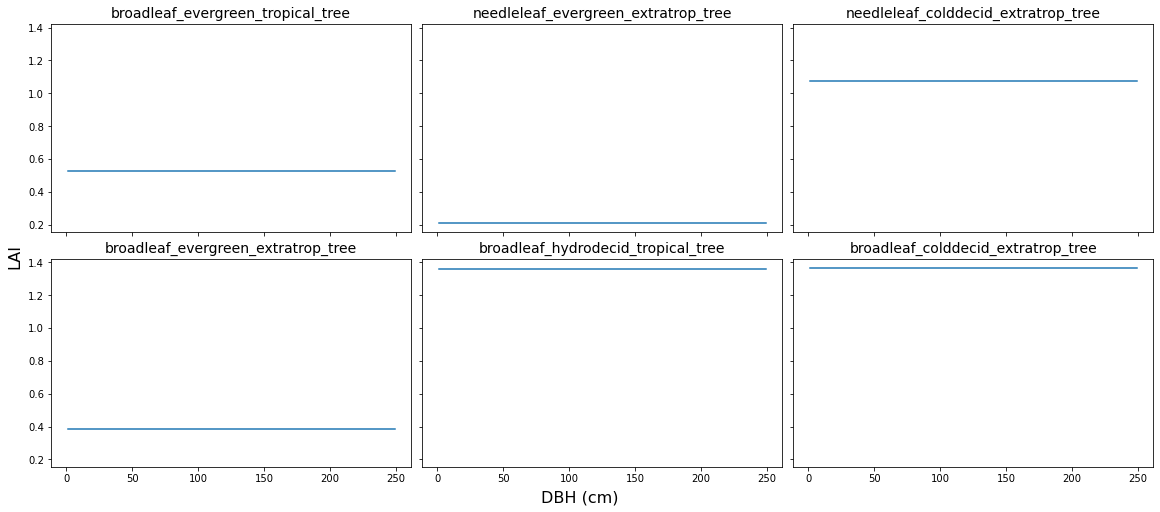

In [14]:
fig2, axs = plt.subplots(nrows=2,ncols=3,
                        figsize=(16,7), constrained_layout=True, sharex=True, sharey=True)

axs = axs.flatten()

# for each tree PFT calculate total vai
for pf in range(0, 6) : 
    
    dbh = np.arange(1,250,1)
    
    # calculate leaf carbon
    leaf_c_curve = d2bleaf(dbh, d2bl1[pf], d2bl2[pf], c2b = 2.0) 
    
    # calculate crown area
    ca_curve = d2ca(dbh, d2bl2[pf])
    
    lai_curve = [tree_lai( leaf_c, c_area, vcmax25top[pf], slatop[pf], slamax[pf])
             for leaf_c, c_area in zip(leaf_c_curve, ca_curve)]
    
    axs[pf].plot(dbh, lai_curve)
    axs[pf].set_title(pftnames[pf], fontsize=14)

fig2.supylabel('LAI', fontsize=16)
fig2.supxlabel('DBH (cm)', fontsize=16)  
;

### Plot leaf biomass

Text(0.5, 0.01, 'DBH (cm)')

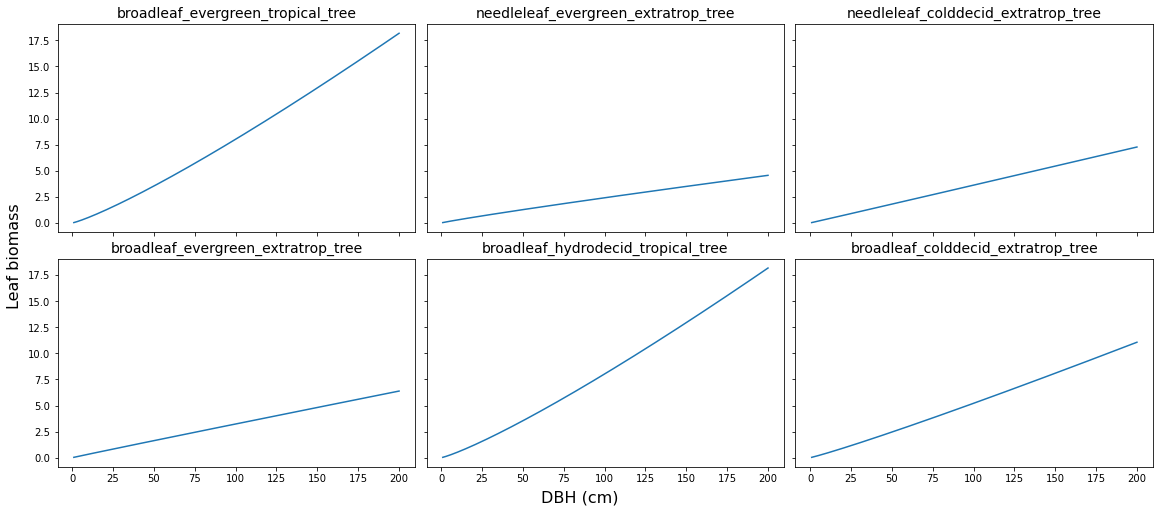

In [15]:
fig2, axs = plt.subplots(nrows=2,ncols=3,
                        figsize=(16,7), constrained_layout=True, sharex=True, sharey=True)

axs = axs.flatten()

dbh = np.linspace(1,200,200)

for pf in range(0,6):
    bleaf_curve = [d2bleaf(d, d2bl1[pf], d2bl2[pf], c2b = 2.0)  for  d  in dbh]
    axs[pf].plot(dbh, bleaf_curve)
    axs[pf].set_title(pftnames[pf], fontsize=14)

fig2.supylabel('Leaf biomass', fontsize=16)
fig2.supxlabel('DBH (cm)', fontsize=16)    

### Plot crown area

Text(0.5, 0.01, 'DBH (cm)')

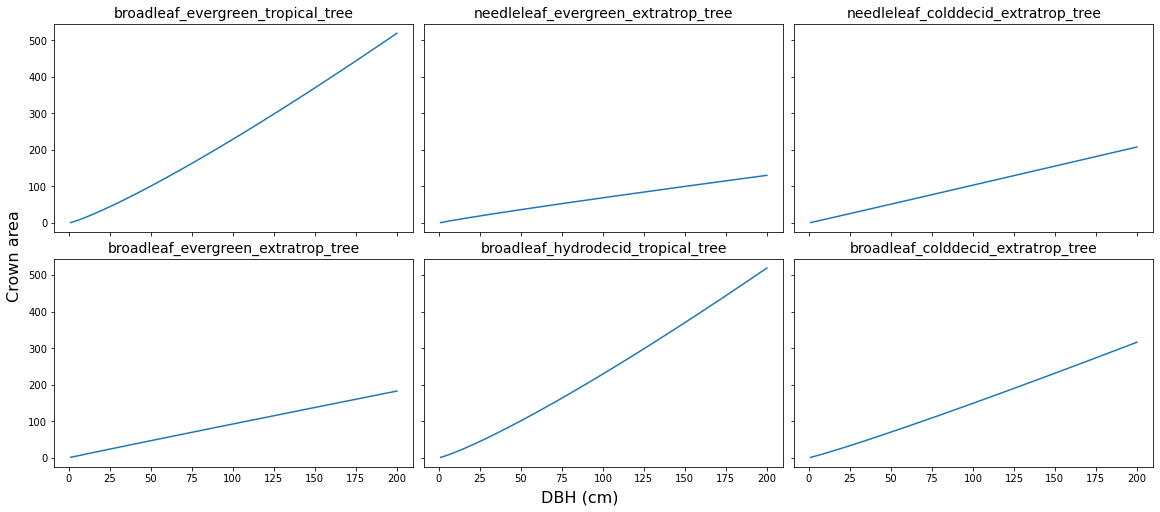

In [16]:
fig2, axs = plt.subplots(nrows=2,ncols=3,
                        figsize=(16,7), constrained_layout=True, sharex=True, sharey=True)

axs = axs.flatten()

dbh = np.linspace(1,200,200)

for pf in range(0,6):
    ca_curve = [d2ca(d, d2bl2[pf])  for  d  in dbh]
    axs[pf].plot(dbh, ca_curve)
    axs[pf].set_title(pftnames[pf], fontsize=14)

fig2.supylabel('Crown area', fontsize=16)
fig2.supxlabel('DBH (cm)', fontsize=16)    